## **Введение**

### Цель работы
Цель выполнения работы:

- изучить метод разностных аппроксимаций для волнового уравнения, составить алгоритмы решения волнового уравнения методом сеток, применимым для организации вычислений на ПЭВМ;
- составить программы волнового уравнения по разработанным алгоритмам;
- выполнить тестовые примеры и проверить правильность работ программ.
- получить численное решение волнового уравнения.


### Условия задания

Условия задания были выбраны исходя из варианта

In [18]:
VARIANT_NUMBER = 8

## **Программная реализация**

Характеристики устройства:
* Операционная система: Windows 10
* Процессор: Intel Core i5 10TH GEN
* Объем и тип оперативной памяти: 16 Gb DDR4
* Тип диска, на которой установленна ОС: SSD

В качестве языка программирования использован Python 3  и среда программирования Visual Studio Code. Использовались библиотеки numpy - для работы с матрицами, векторизации функций, matplolib - для визуализации, а также встроенная библиотека с простейшими математическими функциями math.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from math import *


%matplotlib inline

## Задание 1

Рассчитать колебания $u(x,t)$.

Продольные колебания $u(x,t)$ тяги описываются уравнением $$ \frac{\partial^2u}{\partial t^2} - \frac{\rho}{E}\frac{\partial^2u}{\partial x^2} = 0, \\ 0 \lt x \lt L,  \\ u(0,t)=0, u(L,t)=0, 0 \le t \lt T $$

где $E$ - модуль упругости; $\rho$ - плотность материала стержня.

Тяга имеет длину $L$ и закреплена на концах. Захватив тягу в центре, ее деформируют так, что продольное перемещение становиться равным $\Delta u$:$$u(x,0) = -\frac{\rho}{E}\frac{\partial^2u}{\partial x^2}$$Затем тяга освобождается.

Рассчитайте колебания $u(x,t)$ при заданных параметрах.

Аппроксимируем вторые производные:$$ \frac {\partial^2 u}{\partial x^2} = \frac {u(x+h, t) - 2u(x, t) + u(x-h, t)}{h^2} $$$$ \frac {\partial^2 u}{\partial t^2} = \frac {u(x, t+\tau) - 2u(x, t) + u(x, t-\tau)}{t^2} $$

Тогда получим:$$\frac {(u_{j}^{i+1} - 2\cdot u_j^i + u_{j}^{i-1})}{\tau^2} = \frac{\rho}{E} \frac {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)}{h^2}
$$ 
Выражаем отсюда $u_{j}^{i+1}$:$$
u_{j}^{i+1} = \frac{ \rho \tau^2}{E h^2} {(u_{j+1}^i - 2\cdot u_j^i + u_{j-1}^i)} + 2\cdot u_j^i - u_{j}^{i-1};
$$
Получили явную трехслойную схему с шаблоном крест.

Требуется выразить первые два слоя. Для этого воспользуемся начальными условиями:
$$
u(x, 0) = p(x),\ \frac {\partial u(x, 0)}{\partial t} = q(x),\ u(0, t)= 0,\ u(L, t) = 0
$$
Из условия $u(x, 0) = p(x)$ можно получить значения для первого слоя. Второй слой получим из разложения функции $u(x, t)$ в ряд Тейлора, при этом раскладывать будем по $t$:
$$
u_{j}^1 = u_{j}^0 + \tau \cdot \frac {\partial u_{j}^0}{\partial t} + \frac {\tau^2}{2} \frac {\partial u_{j}^0}{\partial t^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 \rho}{2\cdot E} \frac {\partial^2 u_j}{\partial x^2} = p_{j} + \tau \cdot q_{j} + \frac {\tau^2 \rho}{2\cdot h^2 E} (p_{j+1} - 2\cdot p_j + p_{j-1})
$$

Получив значения для первых двух слоев, по схеме, описанной выше, можно получить последующие слои.

In [20]:
L = 15.0
u = 0.1
E = 86.0 * 10**9
ro = 8.5 * 10**3

p = lambda x: -4.0 * u / (L ** 2) * x ** 2  + 4 * u / L * x 
q = lambda x: 0 

In [21]:
def compute_first_and_second_layer(h: float, theta: float) -> tuple:
    x = np.arange(0, L + h, h)
    first_layer = np.zeros(x.size)
    first_layer[1:-1] = np.vectorize(p)(x[1:-1])

    second_layer = np.zeros(x.size)
    second_layer[1:-1] = first_layer[1:-1] + theta * np.vectorize(q)(x[1:-1]) +  (theta**2 * E) / (2 * h**2*ro) * \
        (first_layer[2:] - 2 * first_layer[1:-1] + first_layer[:-2])
    
    return first_layer, second_layer

def compute_next_layer(previous_layer: np.array, 
                       previous_previous_layer: np.array, 
                       h: float, theta: float) -> np.array:
    
    new_layer = np.zeros(previous_layer.size)
    new_layer[1 : -1] = (theta**2 * E) / (h**2 * ro) * \
    (previous_layer[2:] - 2 * previous_layer[1:-1] + previous_layer[:-2]) + 2 * previous_layer[1:-1] - previous_previous_layer[1:-1]
    return new_layer

def solve(h: float, theta: float, upper_bound: float) -> np.array:
    layers = []
    previous_layer, current_layer = compute_first_and_second_layer(h, theta)
    
    layers.append(previous_layer.copy())
    layers.append(current_layer.copy())
    for _ in np.arange(2 * theta, upper_bound + theta, theta):
        next_layer = compute_next_layer(current_layer, previous_layer, h, theta)
        layers.append(next_layer.copy())
        previous_layer, current_layer = current_layer, next_layer
    return np.array(layers)


def plot_solution_3d(solution: np.array, h: float, theta: float, upper_bound: float) -> None:
    x = np.arange(0, L + h, h)
    y = np.arange(0, upper_bound + theta, theta)
    
    X, Y = np.meshgrid(x, y)
    figure = plt.figure(figsize=(10, 10))
    
    ax = figure.add_subplot(projection='3d')
    ax.plot_surface(X, Y, solution, antialiased=True)
    
def plot_solution_2d(solution: np.array, h: float, theta: float, 
                     from_layer: int, to_layer: int, step_layer: int) -> None:
    figure = plt.figure(figsize=(10, 10))
    x = np.arange(0, L + h, h)

    for i in range(from_layer, to_layer, step_layer):
        plt.plot(x, solution[i], label='Время={:01.5f}'.format(theta * i))
    plt.legend()

In [22]:
solution = solve(0.1, 0.00001, 2)

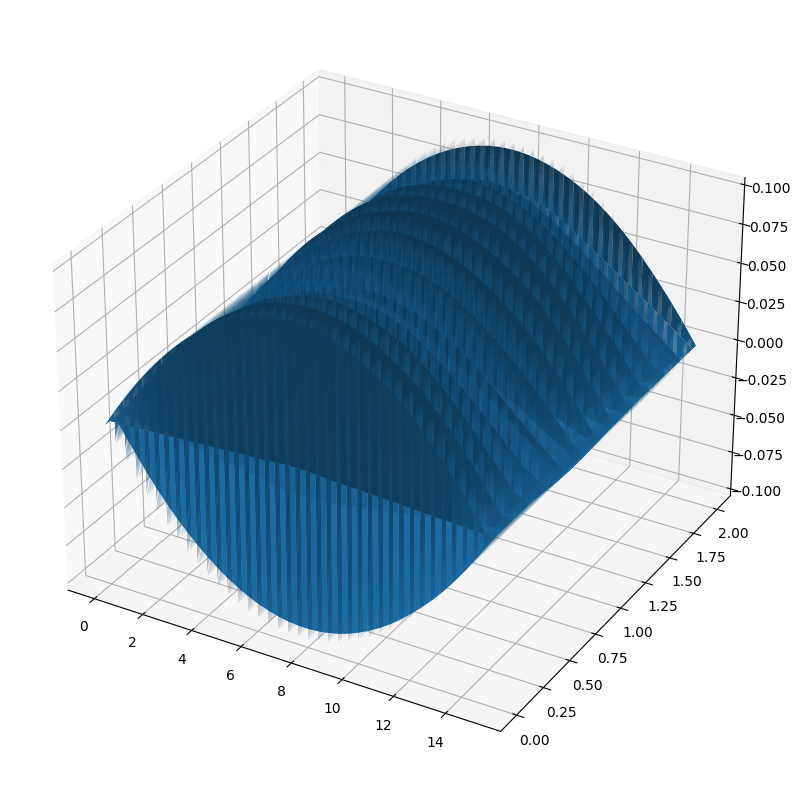

In [23]:
plot_solution_3d(solution, 0.1, 0.00001, 2)

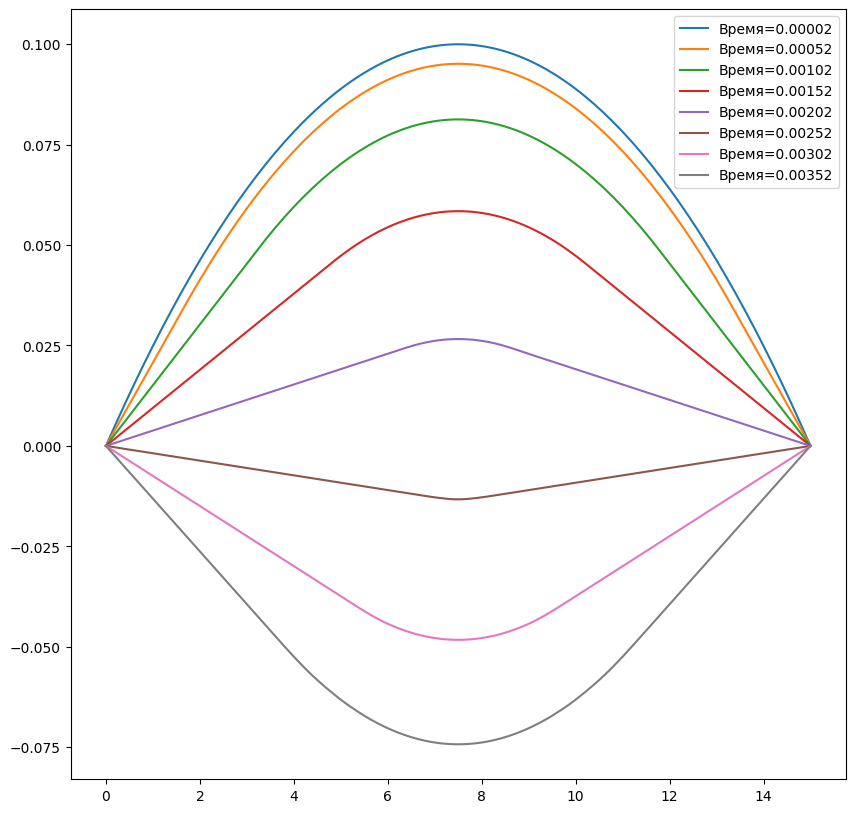

In [24]:
plot_solution_2d(solution, 0.1, 0.00001, 2, 400, 50)

Данные графики соотносятся с реальной физикой моделируемого процесса.

## Задание 2

Рассчитать колебания тонкой пластины

Колебания тонкой пластины без учета потерь на трение описываются нормированным волновым уравнением вида

$$ \frac{\partial^2u}{\partial t^2} - (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2}) = 0, \ 0 \le t \le T,\ -\frac a 2 \le x \le \frac a 2,\ -\frac b 2 \le y \le \frac b 2$$
где $u(x,y,t)$ - деформация пластины; $x, y$ - координаты; $t$ - время.

Рассчитать колебания пластины при заданных размерах $a$ и $b$, граничных $\Gamma_1, \Gamma_2, \Gamma_3, \Gamma_4$, и начальных $u(x,y,0)$ и $\frac{\partial u(x,y,0)}{\partial t}$ условиях.

Аппроксимируем вторые производные:$$ \frac {\partial^2 u}{\partial x^2} = \frac {u(x+h,y, t) - 2u(x,y, t) + u(x-h,y, t)}{h^2} $$$$ \frac {\partial^2 u}{\partial y^2} = \frac {u(x,y+h, t) - 2u(x,y, t) + u(x,y-h, t)}{h^2} $$$$ \frac {\partial^2 u}{\partial t^2} = \frac {u(x, y, t+\tau) - 2u(x,y, t) + u(x,y, t-\tau)}{t^2} $$

Тогда получим:$$
\frac {u^{i+1}_{j,k} - 2\cdot u^i_{j,k} + u^{i-1}_{j,k}}{\tau ^2} = \frac{u^{i}_{j+1, k} - 2\cdot u^i_{j,k} + u^{i}_{j-1, k}}{h_x^2} + \frac{u^{i}_{j, k+1} - 2\cdot u^i_{j,k} + u^{i}_{j, k-1}}{h_y^2}
$$

Выражем отсюда $u^{i+1}_{j,k} $:

$$
u^{i+1}_{j,k} = \frac{\tau^2}{h_x^2} (u^{i}_{j+1, k} - 2\cdot u^i_{j,k} + u^{i}_{j-1, k}) + \frac{\tau^2}{h_y^2} (u^{i}_{j, k+1} - 2\cdot u^i_{j,k} + u^{i}_{j, k-1}) + 2\cdot u^i_{j,k} - u^{i-1}_{j,k};
$$
Имеем следующие граничные и начальные условия:$$
u(x, y, 0) = p(x, y),\ \frac {\partial u( x, y, 0)}{\partial t} = q(x, y),\ u( -\frac a 2 , y, t) = 0,\ u( \frac a 2 , y, t) = 0,\ \frac {\partial u( x, -\frac b 2 ,t)}{\partial y} = 0,\ \frac {\partial u( x, \frac b 2 ,t)}{\partial y} = 0
$$

А также начальные и граничые равенства для схемы:

$$
u_{j,k}^0 = p_{j,k}; 
$$$$
u_{j,K}^i = u_{j,K-1}^i;
$$$$
u_{j,0}^i = u_{j,1}^i;
$$

In [25]:
a = 3
b = 2
p = lambda x, y: np.tan(np.cos(np.pi * y) / b)
q = lambda x, y: np.exp(np.sin(pi * x / a) * np.sin(2 * pi * y / b))

NX = 100
NY = 100
hx = a / NX
hy = b / NY
t = 0.001
NT = 10000



In [26]:
def solve():
    tensor = np.zeros(shape=(NT, NX, NY))
    X = np.array([np.linspace(-a/2, a/2, NX)]).T
    Y = np.array([np.linspace(-b/2, b/2, NY)])
    tensor[0, 1:-1, :] = p(X[1:-1],Y)
    tensor[1, 1:-1, 1:-1] = p(X[1:-1], Y[:, 1:-1]) + t * q(X[1:-1], Y[:, 1:-1]) + (t / hx) ** 2 / 2 * (p(X[2:], Y[:, 1:-1]) - 2*p(X[1:-1], Y[:, 1:-1]) + p(X[:-2], Y[:, 1:-1])) + (t / hy) ** 2 / 2 * (p(X[1:-1], Y[:, 2:]) - 2*p(X[1:-1], Y[:, 1:-1]) + p(X[1:-1], Y[:, :-2]))
    
    tensor[1, 0, 1:-1] = tensor[1, 1, 1:-1]
    tensor[1, -1, 1:-1] = tensor[1, -2, 1:-1]
    
    
    for i in range(2, NT):
        tensor[i, 1:-1, 1:-1] = (t / hx)**2 * (tensor[i-1, 2:, 1:-1] - 2 * tensor[i-1, 1:-1, 1:-1] + tensor[i-1, :-2, 1:-1]) + (t / hy)**2 * (tensor[i-1, 1:-1, 2:] - 2 * tensor[i-1, 1:-1, 1:-1] + tensor[i-1, 1:-1, :-2]) + 2 * tensor[i-1, 1:-1, 1:-1] - tensor[i-2, 1:-1, 1:-1]
        tensor[i, 0, 1:-1] = tensor[i, 1, 1:-1]
        tensor[i, -1, 1:-1] = tensor[i, -2, 1:-1]
        
    return tensor

def plot_solution(solution: np.array, time_layer: int) -> None:
    time_layer = solution[time_layer]
    
    x = np.linspace(-a/2, a/2, NX)
    y = np.linspace(-b/2, b/2, NY)
    
    X, Y = np.meshgrid(x, y)
    figure = plt.figure(figsize=(10, 10))
    
    ax = figure.add_subplot(projection='3d')
    ax.plot_surface(X, Y, time_layer, antialiased=True)
    

In [27]:
solution = solve()

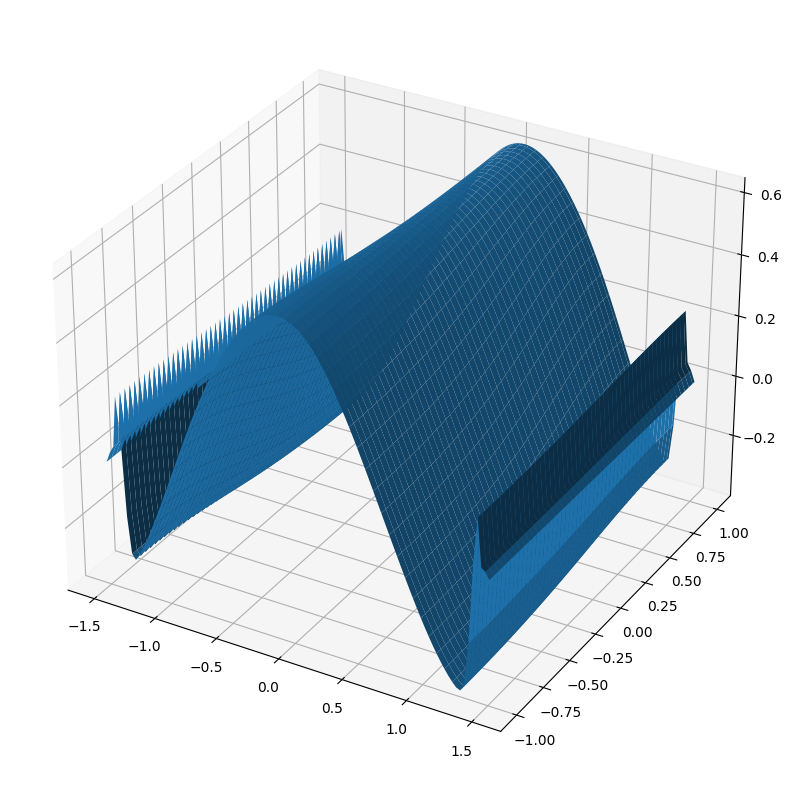

In [28]:
plot_solution(solution, 100)

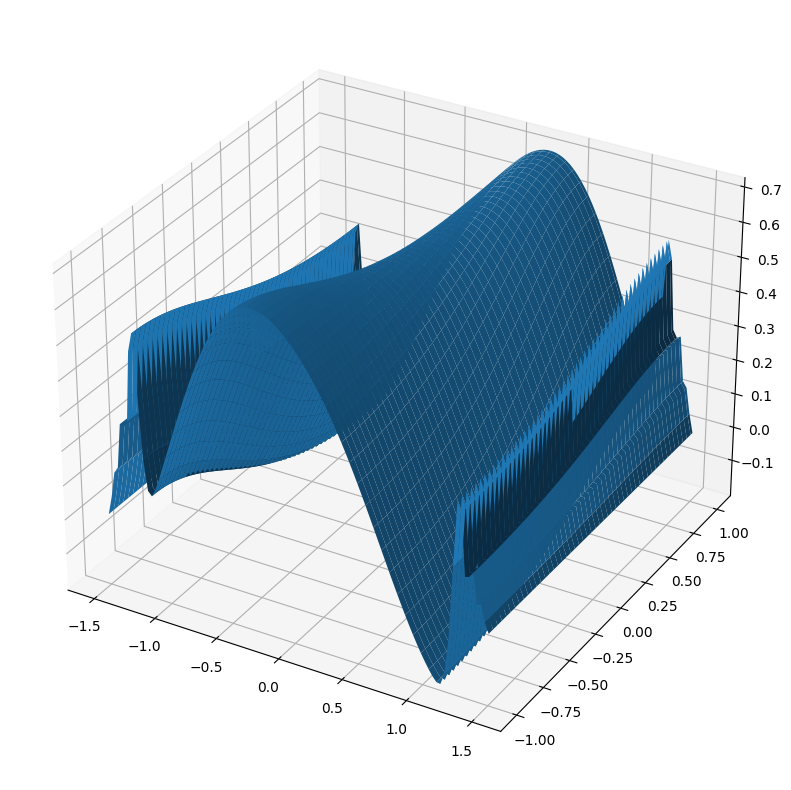

In [29]:
plot_solution(solution, 200)

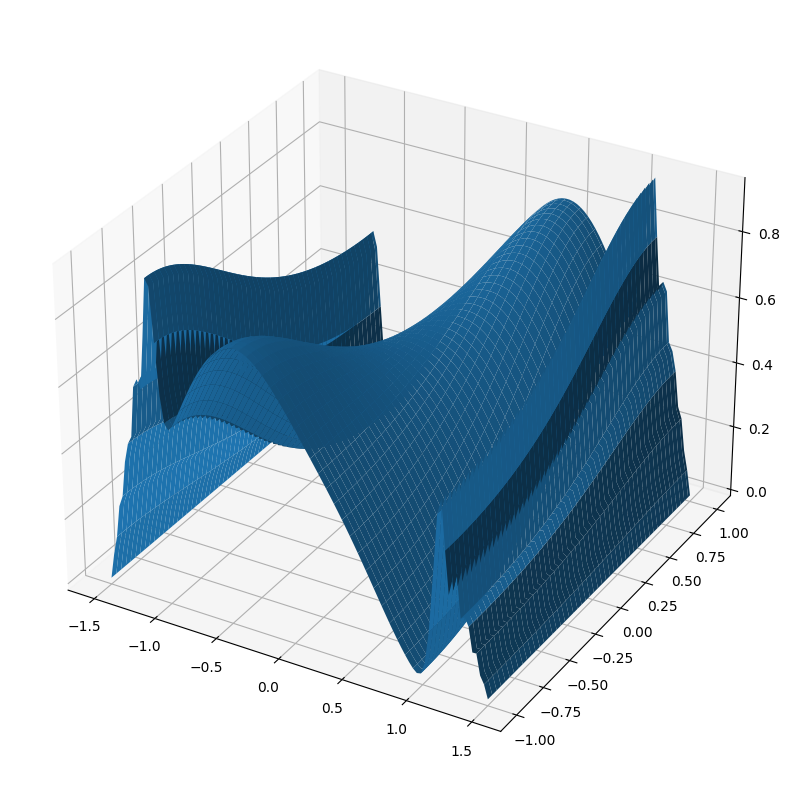

In [30]:
plot_solution(solution, 300)

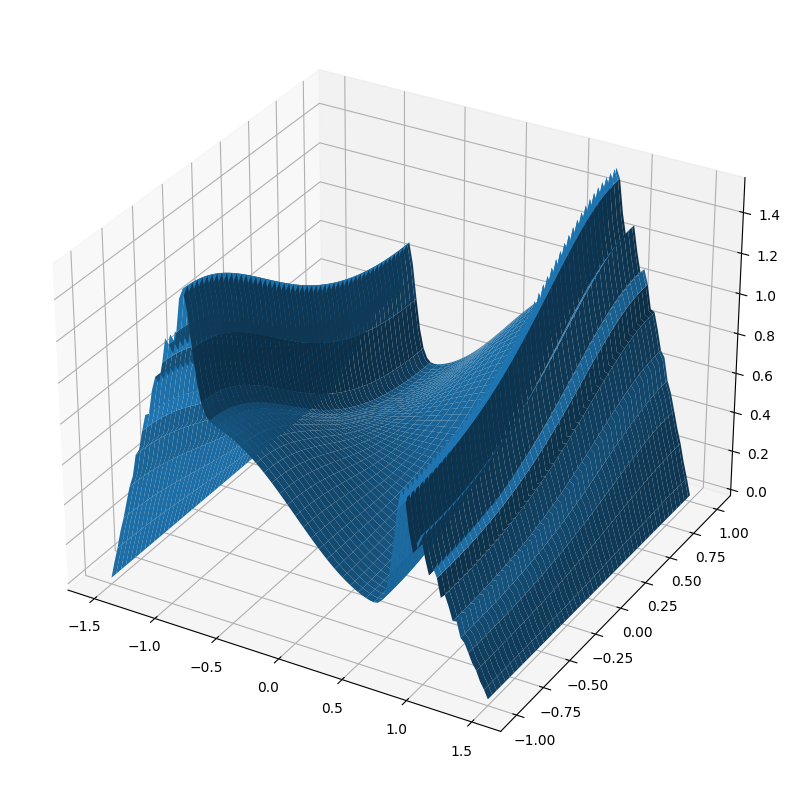

In [31]:
plot_solution(solution, 500)

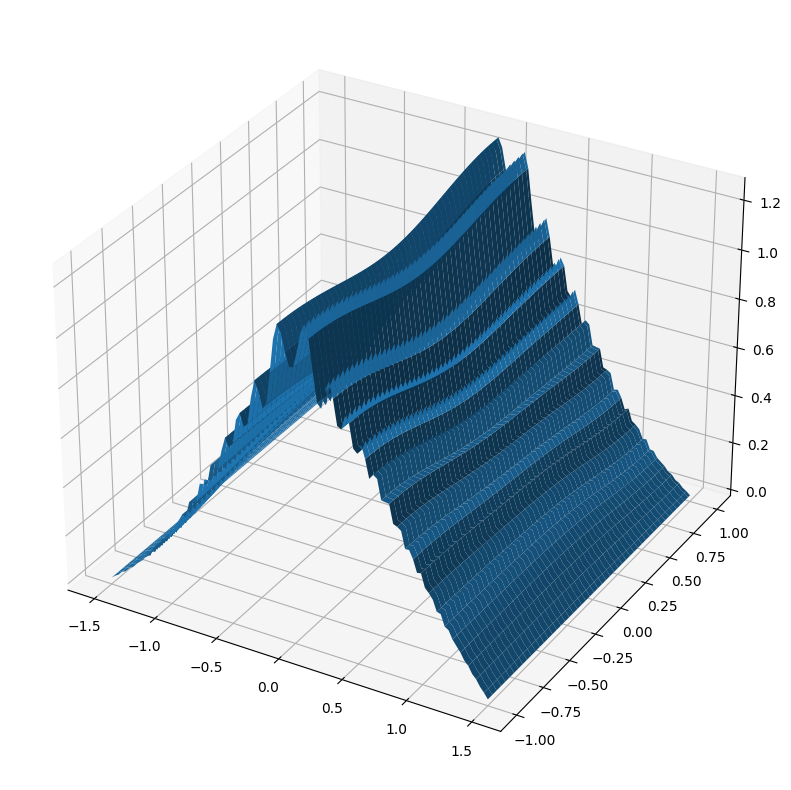

In [32]:
plot_solution(solution, 1000)

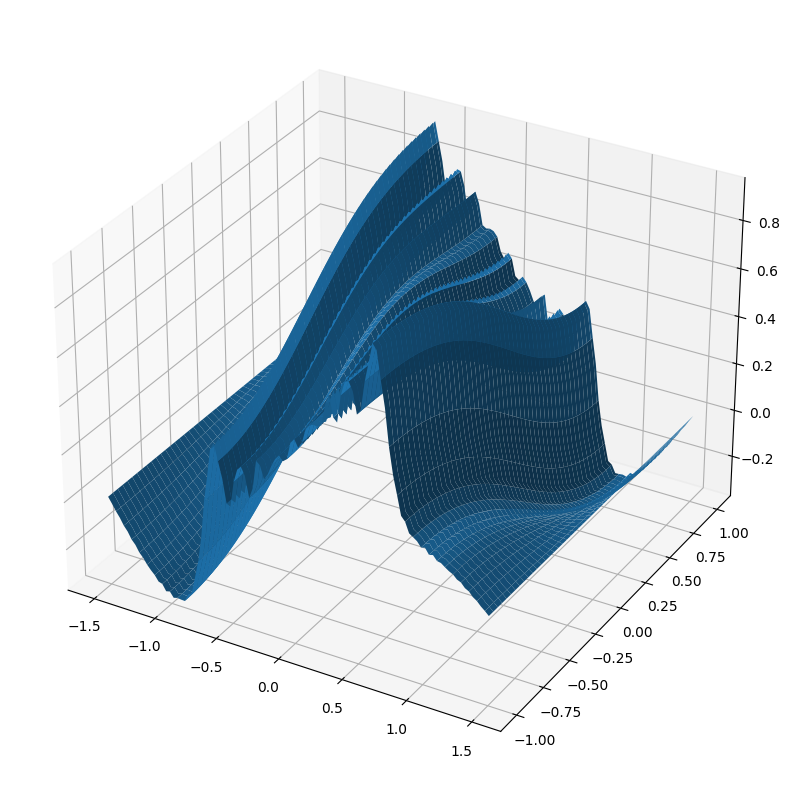

In [33]:
plot_solution(solution, 1500)

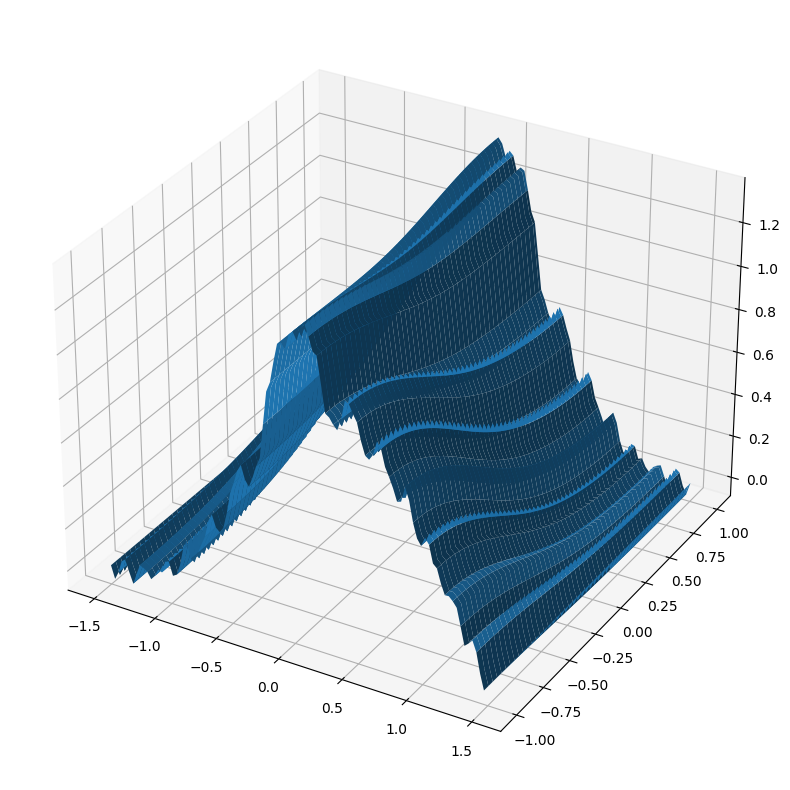

In [34]:
plot_solution(solution, 5000)

## Вывод

В данной лабораторной работе я разработал функции для решения волновых уравнения, а также рассмотрел графики полученных решений.

В первом задании было рассмотрено одномерное волновое уравнение. Для решения были разработаны функции, вычисляющие решения слой за слоем, первые два слоя были получены из начальных условий. Полученные графики подтверждают корректность работы алгоритма.

Во втором задании был разработан алгоритм решения двумерного волнового уравнения, а также представлена визуализация процесса его работы. При реализации алгоритма использовались возможно библиотеки numpy по работе с тензорами (в силу того что решение представляется в виде тензора третьего ранга). Полученные графики также подтверждают корректность работы алгоритма. 